# Week 3: User Segmentation


In [2]:
import pandas as pd
import numpy as np
from faker import Faker

fake = Faker()
categories = ['Groceries', 'Dining Out', 'Transport', 'Entertainment', 'Utilities', 'Healthcare']
users = [f'user_{i}' for i in range(100)]  # 100 synthetic users
data = []
for _ in range(5000):
    user = np.random.choice(users)
    amount = np.random.uniform(5, 500)
    cat = np.random.choice(categories)
    data.append({'user_id': user, 'amount': amount, 'category': cat})
df = pd.DataFrame(data)
df.to_csv('../data/synthetic_users_expenses.csv', index=False)

Original data shape: (5000, 3)

First few rows of raw data:
   user_id      amount    category
0  user_36  335.899169   Utilities
1  user_81  325.183660   Transport
2  user_40  339.239504   Transport
3  user_60   86.786657   Transport
4  user_89  199.723005  Dining Out

Data structure: Each row is ONE transaction (user_id, amount, category)

After pivot_table - User spending matrix:
Shape: (100, 6) (rows=users, columns=categories)

Each row = one user's spending profile
Each column = total spending in that category
category   Dining Out  Entertainment    Groceries   Healthcare    Transport  \
user_id                                                                       
user_0    1713.803192    2235.997053  1586.629262  3352.595706  2412.534317   
user_1    2151.625906    1254.416403  2860.069357  1927.544220  2445.873365   
user_10   2139.372898    2393.872677  2122.127382  1873.370309  2577.638840   
user_11   2126.865584    2429.540985  2676.333529  1166.026392  2719.360141   
user_

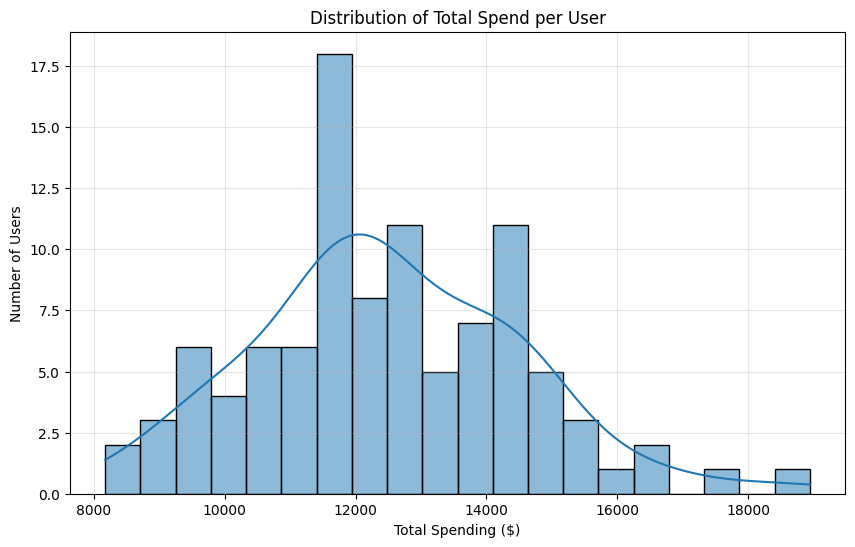


FINAL USER PROFILE DATASET:
This is our FEATURE MATRIX for clustering:
- Each row = one user
- Each column = a feature (spending in category X, or total_spend)
- Ready for unsupervised learning algorithms!
category  user_id   Dining Out  Entertainment    Groceries   Healthcare  \
0          user_0  1713.803192    2235.997053  1586.629262  3352.595706   
1          user_1  2151.625906    1254.416403  2860.069357  1927.544220   
2         user_10  2139.372898    2393.872677  2122.127382  1873.370309   
3         user_11  2126.865584    2429.540985  2676.333529  1166.026392   
4         user_12  1753.915613     439.481854  1621.272154   944.488519   

category    Transport    Utilities   total_spend  
0         2412.534317  2381.423244  13682.982774  
1         2445.873365  1280.734822  11920.264073  
2         2577.638840  3300.542645  14406.924752  
3         2719.360141  3139.765755  14257.892385  
4         2814.487282  2102.230902   9675.876324  

Dataset shape: (100, 8)
Features: [

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# UNSUPERVISED LEARNING CONCEPTS - USER SEGMENTATION
# ============================================================================
# Unsupervised Learning: Finding patterns in data WITHOUT labeled examples
# - No "correct answer" provided (unlike classification where we know categories)
# - Goal: Discover hidden structure, groups, or patterns
# - Common techniques: Clustering (K-Means, DBSCAN), Dimensionality Reduction (PCA)
#
# User Segmentation: Grouping users based on similar spending behaviors
# - Why? Different users have different spending patterns
# - Example segments: "Big Spenders", "Budget Conscious", "Entertainment Lovers"
# - Business value: Personalized recommendations, targeted marketing
# ============================================================================

# Load data (from prior weeks or synthetic)
df = pd.read_csv('../data/synthetic_users_expenses.csv')  # Adjust path

print("Original data shape:", df.shape)
print("\nFirst few rows of raw data:")
print(df.head())
print("\nData structure: Each row is ONE transaction (user_id, amount, category)")

# ============================================================================
# STEP 1: FEATURE ENGINEERING - Creating User Profiles
# ============================================================================
# Problem: Raw data has many transactions per user (one row per transaction)
# Solution: Aggregate to create ONE row per user with spending features
#
# pivot_table explanation:
# - index='user_id': Each user becomes a row
# - columns='category': Each category becomes a column (feature)
# - values='amount': The values to aggregate
# - aggfunc='sum': Sum all transactions for each user-category combination
# - fill_value=0: If a user never spent in a category, set to 0 (not NaN)
#
# Result: Each user now has 6 features (one per category) showing their spending
# ============================================================================

user_df = df.pivot_table(
    index='user_id',           # Rows: one per user
    columns='category',        # Columns: one per spending category
    values='amount',           # Values: transaction amounts
    aggfunc='sum',             # Sum all transactions per user-category
    fill_value=0               # Missing = 0 (user didn't spend in that category)
)

print("\n" + "="*70)
print("After pivot_table - User spending matrix:")
print("="*70)
print(f"Shape: {user_df.shape} (rows=users, columns=categories)")
print("\nEach row = one user's spending profile")
print("Each column = total spending in that category")
print(user_df.head())

# ============================================================================
# STEP 2: ADDING DERIVED FEATURES
# ============================================================================
# total_spend: Sum of all category spending for each user
# Why? This gives us an overall spending level feature
# - Helps identify "high spenders" vs "low spenders"
# - Useful for clustering algorithms to find spending-based segments
# ============================================================================

user_df['total_spend'] = user_df.sum(axis=1)  # Sum across all category columns
print("\n" + "="*70)
print("After adding total_spend feature:")
print("="*70)
print(user_df.head())

# ============================================================================
# STEP 3: RESET INDEX FOR VISUALIZATION
# ============================================================================
# reset_index(): Converts 'user_id' from index to a regular column
# Why? Makes it easier to use in plotting and further analysis
# ============================================================================

user_df = user_df.reset_index()  # user_id becomes a column instead of index

# ============================================================================
# STEP 4: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
# Before clustering, we need to understand our data distribution
# Histogram shows: How are total spending amounts distributed?
# - Helps identify if there are natural groups (bimodal, multimodal)
# - Informs us about data scale (important for feature scaling later)
# ============================================================================

plt.figure(figsize=(10,6))
sns.histplot(user_df['total_spend'], bins=20, kde=True)
plt.title('Distribution of Total Spend per User')
plt.xlabel('Total Spending ($)')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*70)
print("FINAL USER PROFILE DATASET:")
print("="*70)
print("This is our FEATURE MATRIX for clustering:")
print("- Each row = one user")
print("- Each column = a feature (spending in category X, or total_spend)")
print("- Ready for unsupervised learning algorithms!")
print("="*70)
print(user_df.head())
print(f"\nDataset shape: {user_df.shape}")
print(f"Features: {list(user_df.columns)}")

BEFORE SCALING - Feature Statistics:
Notice how features have VERY different scales:
category   Dining Out  Entertainment    Groceries   Healthcare    Transport  \
count      100.000000     100.000000   100.000000   100.000000   100.000000   
mean      1994.325841    2115.644176  2153.680696  2123.776386  1952.515072   
std        665.503714     907.445776   802.829706   892.112410   712.955215   
min        216.358696     167.329188   207.017685   673.106837   451.568015   
25%       1585.001000    1389.408782  1616.108699  1403.592113  1457.547720   
50%       1982.930546    2103.225195  2156.770696  2029.708689  1923.489658   
75%       2452.241231    2773.570268  2678.659910  2652.473788  2436.421621   
max       3812.311068    4154.512583  4380.002779  4399.690282  3652.504396   

category    Utilities   total_spend  
count      100.000000    100.000000  
mean      2153.734342  12493.676514  
std        944.202414   2033.066243  
min        675.364160   8176.073722  
25%       142

/var/folders/wc/d50td_fd3y79bpzgzcdvhgp80000gn/T/ipykernel_58252/3802560350.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([X[col] for col in X.columns[:3]], labels=X.columns[:3])
/var/folders/wc/d50td_fd3y79bpzgzcdvhgp80000gn/T/ipykernel_58252/3802560350.py:96: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([X_scaled_df[col] for col in X_scaled_df.columns[:3]],


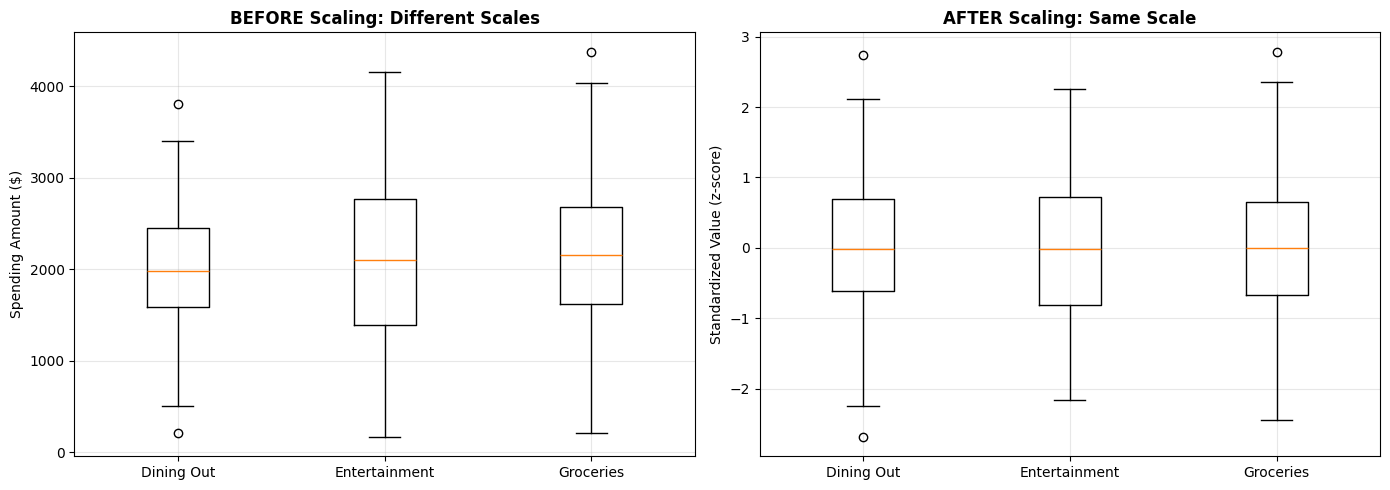


KEY INSIGHT:
Left plot: Features have different ranges → clustering biased
Right plot: Features on same scale → fair comparison

Now clustering will find users with SIMILAR SPENDING PATTERNS
regardless of whether they're high or low spenders overall!

WHAT HAPPENS NEXT?
X_scaled is now ready for clustering algorithms:
- K-Means: Groups users into k clusters based on distance
- Each cluster = users with similar spending behavior
- We can then analyze: 'What makes Cluster 1 different from Cluster 2?'

Final scaled feature matrix shape: (100, 7)
  - Rows: 100 users
  - Columns: 7 features (all scaled to mean=0, std=1)

✅ Ready for clustering!


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# CRITICAL CONCEPT: FEATURE SCALING FOR CLUSTERING
# ============================================================================
# Why Scale Features?
# - Clustering algorithms (K-Means, etc.) use DISTANCE to find similar users
# - Distance = how "far apart" two users are in feature space
# - Problem: Features with LARGER values dominate distance calculations
#
# Example Problem:
#   User A: Groceries=$5000, Entertainment=$50
#   User B: Groceries=$5100, Entertainment=$50
#   Distance = sqrt((5000-5100)² + (50-50)²) = 100
#
#   User C: Groceries=$5000, Entertainment=$50
#   User D: Groceries=$5000, Entertainment=$150
#   Distance = sqrt((5000-5000)² + (50-150)²) = 100
#
# Both pairs have same distance, but:
# - A & B differ by 2% in Groceries (similar users!)
# - C & D differ by 200% in Entertainment (very different!)
#
# Solution: StandardScaler normalizes all features to same scale
# ============================================================================

# Prepare features (drop user_id - it's not a feature, just an identifier)
X = user_df.drop('user_id', axis=1).copy()  # Keep only numerical features

print("="*70)
print("BEFORE SCALING - Feature Statistics:")
print("="*70)
print("Notice how features have VERY different scales:")
print(X.describe())
print("\nExample: 'total_spend' ranges from ~5000 to ~15000")
print("         Individual categories range from ~0 to ~4000")
print("         This imbalance will bias clustering toward high-spend features!")

# ============================================================================
# STANDARD SCALER EXPLAINED
# ============================================================================
# StandardScaler performs Z-score normalization:
#   scaled_value = (original_value - mean) / standard_deviation
#
# Result:
# - Mean of each feature = 0
# - Standard deviation of each feature = 1
# - All features now on the SAME scale
#
# Why this works:
# - Distance calculations treat all features equally
# - Clustering finds patterns based on RELATIVE spending, not absolute amounts
# ============================================================================

# Create preprocessor pipeline
# ColumnTransformer: Apply same transformation to all columns
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)  # Scale all features
])

# Fit: Learn the mean and std from training data
# Transform: Apply the scaling
X_scaled = preprocessor.fit_transform(X)

# Convert back to DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("\n" + "="*70)
print("AFTER SCALING - Feature Statistics:")
print("="*70)
print(X_scaled_df.describe())
print("\nNotice:")
print("- Mean ≈ 0 for all features (actually 0.0)")
print("- Std ≈ 1 for all features (actually 1.0)")
print("- All features now on EQUAL footing!")

# ============================================================================
# VISUAL COMPARISON: Before vs After Scaling
# ============================================================================
# Let's visualize why scaling matters
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
axes[0].boxplot([X[col] for col in X.columns[:3]], labels=X.columns[:3])
axes[0].set_title('BEFORE Scaling: Different Scales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Spending Amount ($)')
axes[0].grid(True, alpha=0.3)

# After scaling
axes[1].boxplot([X_scaled_df[col] for col in X_scaled_df.columns[:3]], 
                labels=X_scaled_df.columns[:3])
axes[1].set_title('AFTER Scaling: Same Scale', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Standardized Value (z-score)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT:")
print("="*70)
print("Left plot: Features have different ranges → clustering biased")
print("Right plot: Features on same scale → fair comparison")
print("\nNow clustering will find users with SIMILAR SPENDING PATTERNS")
print("regardless of whether they're high or low spenders overall!")

print("\n" + "="*70)
print("WHAT HAPPENS NEXT?")
print("="*70)
print("X_scaled is now ready for clustering algorithms:")
print("- K-Means: Groups users into k clusters based on distance")
print("- Each cluster = users with similar spending behavior")
print("- We can then analyze: 'What makes Cluster 1 different from Cluster 2?'")
print("="*70)

print(f"\nFinal scaled feature matrix shape: {X_scaled.shape}")
print(f"  - Rows: {X_scaled.shape[0]} users")
print(f"  - Columns: {X_scaled.shape[1]} features (all scaled to mean=0, std=1)")
print("\n✅ Ready for clustering!")

STEP 1: FINDING THE OPTIMAL NUMBER OF CLUSTERS (k)
Problem: How many user segments should we create?
Solution: Try different k values and evaluate quality

We'll test k from 2 to 9 clusters
For each k, we'll calculate:
  1. Inertia (within-cluster sum of squares)
  2. Silhouette Score (cluster quality measure)

Testing k values: [2, 3, 4, 5, 6, 7, 8, 9]
This may take a moment...

k=2: Inertia=566.72, Silhouette=0.167
k=3: Inertia=498.69, Silhouette=0.146
k=4: Inertia=456.01, Silhouette=0.139
k=5: Inertia=421.20, Silhouette=0.139
k=6: Inertia=394.26, Silhouette=0.144
k=7: Inertia=371.46, Silhouette=0.128
k=8: Inertia=347.99, Silhouette=0.141
k=9: Inertia=324.08, Silhouette=0.149

STEP 2: ELBOW METHOD - Visualizing Inertia
The 'Elbow' is where adding more clusters doesn't help much
Look for the 'bend' in the curve - that's your optimal k


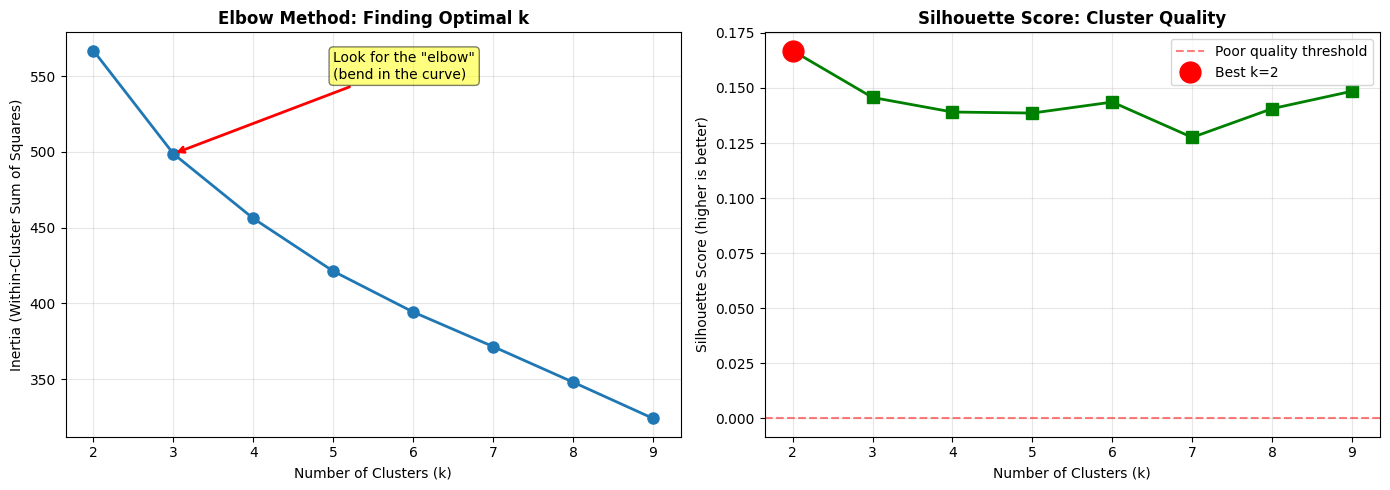


INTERPRETING THE RESULTS:
Left Plot (Elbow Method):
  - Look for where the curve 'bends' sharply
  - After the elbow, adding more clusters doesn't help much
  - This suggests the optimal number of clusters

Right Plot (Silhouette Score):
  - Best k = 2 (highest silhouette score: 0.167)
  - Higher score = better separated, more cohesive clusters

STEP 3: CREATING FINAL CLUSTERS WITH k=3
Creating K-Means model with chosen k and assigning users to clusters...

✅ Clustering complete!
   - 3 clusters created
   - Cluster distribution:
     Cluster 0: 39 users (39.0%)
     Cluster 1: 32 users (32.0%)
     Cluster 2: 29 users (29.0%)

STEP 4: ALTERNATIVE - DBSCAN CLUSTERING
DBSCAN finds clusters based on DENSITY, not centroids
  - eps=0.5: Points within 0.5 units are neighbors
  - min_samples=5: Need 5 points to form a cluster
  - Points that don't fit = labeled -1 (outliers/noise)

✅ DBSCAN complete!
   - 0 clusters found
   - 100 outliers detected (labeled as -1)
   - Cluster distribution:

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ============================================================================
# K-MEANS CLUSTERING: THE CORE ALGORITHM
# ============================================================================
# What is K-Means?
# - Unsupervised learning algorithm that groups similar data points together
# - "K" = number of clusters (groups) you want to find
# - "Means" = algorithm uses cluster centers (centroids) to represent clusters
#
# How K-Means Works (Step by Step):
# 1. Initialize: Randomly place K centroids in feature space
# 2. Assign: Each data point assigned to nearest centroid (by distance)
# 3. Update: Move centroids to center of their assigned points
# 4. Repeat: Steps 2-3 until centroids stop moving (convergence)
#
# Example with 2D data:
#   - You have points on a 2D plane
#   - K-Means finds K "center points" (centroids)
#   - All points near centroid 1 → Cluster 1
#   - All points near centroid 2 → Cluster 2
#   - etc.
#
# In our case (multi-dimensional):
#   - Each user is a point in 7D space (7 spending features)
#   - K-Means finds K centroids in this 7D space
#   - Users near same centroid = similar spending behavior = same segment
# ============================================================================

print("="*70)
print("STEP 1: FINDING THE OPTIMAL NUMBER OF CLUSTERS (k)")
print("="*70)
print("Problem: How many user segments should we create?")
print("Solution: Try different k values and evaluate quality")
print("\nWe'll test k from 2 to 9 clusters")
print("For each k, we'll calculate:")
print("  1. Inertia (within-cluster sum of squares)")
print("  2. Silhouette Score (cluster quality measure)")
print("="*70)

# ============================================================================
# EVALUATION METRICS EXPLAINED
# ============================================================================
# 1. INERTIA (Within-Cluster Sum of Squares - WCSS)
#    - Measures how "tight" or "compact" clusters are
#    - Formula: Sum of squared distances from each point to its centroid
#    - Lower inertia = tighter clusters = better (but can overfit!)
#    - Always decreases as k increases (more clusters = smaller distances)
#
# 2. SILHOUETTE SCORE
#    - Measures how well-separated clusters are
#    - Range: -1 to +1
#    - +1: Perfect separation (points clearly belong to clusters)
#    - 0: Overlapping clusters (ambiguous assignment)
#    - -1: Points assigned to wrong clusters
#    - Higher = better cluster quality
# ============================================================================

# Test different values of k (number of clusters)
inertias = []      # Store inertia for each k
sil_scores = []    # Store silhouette score for each k
k_range = range(2, 10)  # Test k from 2 to 9

print(f"\nTesting k values: {list(k_range)}")
print("This may take a moment...\n")

for k in k_range:
    # Create K-Means model with k clusters
    kmeans = KMeans(
        n_clusters=k,        # Number of clusters to find
        random_state=42,     # Seed for reproducibility
        n_init=10,           # Run algorithm 10 times, pick best result
        max_iter=300         # Maximum iterations per run
    )
    
    # Fit the model and predict cluster labels
    # fit_predict: Does both fitting and prediction in one step
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertia = kmeans.inertia_  # Get the inertia (WCSS)
    sil_score = silhouette_score(X_scaled, labels)  # Calculate silhouette score
    
    inertias.append(inertia)
    sil_scores.append(sil_score)
    
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette={sil_score:.3f}")

print("\n" + "="*70)
print("STEP 2: ELBOW METHOD - Visualizing Inertia")
print("="*70)
print("The 'Elbow' is where adding more clusters doesn't help much")
print("Look for the 'bend' in the curve - that's your optimal k")
print("="*70)

# Create elbow plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Elbow Method (Inertia)
axes[0].plot(list(k_range), inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method: Finding Optimal k', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(k_range))

# Add annotation explaining the elbow
axes[0].annotate(
    'Look for the "elbow"\n(bend in the curve)',
    xy=(3, inertias[1] if len(inertias) > 1 else inertias[0]),
    xytext=(5, inertias[1] * 1.1 if len(inertias) > 1 else inertias[0] * 1.1),
    arrowprops=dict(arrowstyle='->', color='red', lw=2),
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5)
)

# Plot 2: Silhouette Score
axes[1].plot(list(k_range), sil_scores, marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_title('Silhouette Score: Cluster Quality', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score (higher is better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(k_range))
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Poor quality threshold')
axes[1].legend()

# Highlight best k based on silhouette score
best_k_idx = np.argmax(sil_scores)
best_k = list(k_range)[best_k_idx]
axes[1].plot(best_k, sil_scores[best_k_idx], 'ro', markersize=15, label=f'Best k={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETING THE RESULTS:")
print("="*70)
print("Left Plot (Elbow Method):")
print("  - Look for where the curve 'bends' sharply")
print("  - After the elbow, adding more clusters doesn't help much")
print("  - This suggests the optimal number of clusters")
print("\nRight Plot (Silhouette Score):")
print(f"  - Best k = {best_k} (highest silhouette score: {max(sil_scores):.3f})")
print("  - Higher score = better separated, more cohesive clusters")
print("="*70)

# ============================================================================
# KEY INSIGHT: WHY INERTIA ALWAYS DECREASES & HOW TO FIND OPTIMAL K
# ============================================================================
print("\n" + "="*70)
print("⚠️  IMPORTANT: Understanding Inertia vs Optimal k")
print("="*70)
print("FACT: Inertia ALWAYS decreases as k increases")
print("  - k=2 has higher inertia than k=3")
print("  - k=3 has higher inertia than k=4")
print("  - This is NORMAL and EXPECTED!")
print("\n❌ Common Mistake: 'k=2 is best because inertia is highest'")
print("✅ Correct Approach: Find the 'ELBOW' (bend) in the curve")
print("\nHOW TO FIND THE ELBOW:")
print("  1. Look at the RATE OF CHANGE (how steep the drop is)")
print("  2. Find where the curve changes from STEEP → GENTLE")
print("  3. That's your optimal k (usually k=3, 4, or 5, NOT k=2)")
print("\nEXAMPLE:")
print("  k=2→3: Big drop (steep) ← Still improving a lot")
print("  k=3→4: Medium drop (moderate) ← Good improvement")
print("  k=4→5: Small drop (gentle) ← ELBOW HERE!")
print("  k=5→6: Tiny drop (very gentle) ← Diminishing returns")
print("\nWHY k=2 IS USUALLY NOT OPTIMAL:")
print("  - Too few segments = oversimplified")
print("  - Misses important patterns (e.g., 'Entertainment Lovers')")
print("  - Better to have 3-5 meaningful segments")
print("="*70)

# Calculate and show the rate of change (inertia drops)
print("\n" + "="*70)
print("ANALYZING INERTIA DROPS (Rate of Change):")
print("="*70)
inertia_drops = []
for i in range(len(inertias) - 1):
    drop = inertias[i] - inertias[i+1]
    drop_pct = (drop / inertias[i]) * 100 if inertias[i] > 0 else 0
    inertia_drops.append(drop_pct)
    k1, k2 = list(k_range)[i], list(k_range)[i+1]
    print(f"  k={k1}→{k2}: Drop = {drop:.2f} ({drop_pct:.1f}% decrease)")

# Find where the drop becomes small (potential elbow)
if len(inertia_drops) > 0:
    # Find where drop rate decreases significantly
    avg_drop = np.mean(inertia_drops[:2]) if len(inertia_drops) >= 2 else inertia_drops[0]
    elbow_candidates = []
    for i, drop in enumerate(inertia_drops):
        if drop < avg_drop * 0.5:  # Drop is less than 50% of initial average
            elbow_candidates.append(list(k_range)[i+1])
    
    if elbow_candidates:
        print(f"\n💡 Suggested elbow (where drops become small): k={elbow_candidates[0]}")
        print(f"   (Drops become gentle after this point)")
    else:
        print(f"\n💡 Consider k={best_k} based on silhouette score")
print("="*70)

# ============================================================================
# STEP 3: APPLYING K-MEANS WITH CHOSEN k
# ============================================================================
# After analyzing, we choose k=3 (you can change this based on your analysis)
# We'll create the final clustering model
# ============================================================================

chosen_k = 3  # Based on elbow method and silhouette analysis
print(f"\n" + "="*70)
print(f"STEP 3: CREATING FINAL CLUSTERS WITH k={chosen_k}")
print("="*70)
print("Creating K-Means model with chosen k and assigning users to clusters...")

# Create final K-Means model
kmeans_final = KMeans(
    n_clusters=chosen_k,
    random_state=42,
    n_init=10,
    max_iter=300
)

# Fit and predict: Assign each user to a cluster
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to our user dataframe
user_df['cluster'] = cluster_labels

print(f"\n✅ Clustering complete!")
print(f"   - {chosen_k} clusters created")
print(f"   - Cluster distribution:")
cluster_counts = user_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"     Cluster {cluster_id}: {count} users ({count/len(user_df)*100:.1f}%)")

# ============================================================================
# STEP 4: ALTERNATIVE ALGORITHM - DBSCAN
# ============================================================================
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
# - Different approach: Finds clusters based on DENSITY, not distance to centroids
# - Advantages:
#     * Can find irregularly-shaped clusters (K-Means assumes spherical)
#     * Automatically determines number of clusters
#     * Identifies outliers as "noise" (cluster label = -1)
# - Parameters:
#     * eps: Maximum distance between points to be in same cluster
#     * min_samples: Minimum points needed to form a cluster
# - When to use:
#     * When clusters might be non-spherical
#     * When you want to find outliers
#     * When you don't know how many clusters exist
# ============================================================================

print("\n" + "="*70)
print("STEP 4: ALTERNATIVE - DBSCAN CLUSTERING")
print("="*70)
print("DBSCAN finds clusters based on DENSITY, not centroids")
print("  - eps=0.5: Points within 0.5 units are neighbors")
print("  - min_samples=5: Need 5 points to form a cluster")
print("  - Points that don't fit = labeled -1 (outliers/noise)")
print("="*70)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels
user_df['db_cluster'] = dbscan_labels

# Count clusters (including noise)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n✅ DBSCAN complete!")
print(f"   - {n_clusters_dbscan} clusters found")
if n_noise > 0:
    print(f"   - {n_noise} outliers detected (labeled as -1)")
print(f"   - Cluster distribution:")
dbscan_counts = pd.Series(dbscan_labels).value_counts().sort_index()
for cluster_id, count in dbscan_counts.items():
    if cluster_id == -1:
        print(f"     Noise/Outliers: {count} users ({count/len(user_df)*100:.1f}%)")
    else:
        print(f"     Cluster {cluster_id}: {count} users ({count/len(user_df)*100:.1f}%)")

# ============================================================================
# COMPARISON: K-Means vs DBSCAN
# ============================================================================

print("\n" + "="*70)
print("COMPARISON: K-Means vs DBSCAN")
print("="*70)
print("K-Means:")
print("  ✅ Simple, fast, works well for spherical clusters")
print("  ✅ Requires you to specify number of clusters")
print("  ❌ Assumes clusters are roughly spherical")
print("  ❌ Doesn't handle outliers well")
print("\nDBSCAN:")
print("  ✅ Finds irregularly-shaped clusters")
print("  ✅ Automatically finds number of clusters")
print("  ✅ Identifies outliers")
print("  ❌ Sensitive to parameters (eps, min_samples)")
print("  ❌ Can struggle with varying density")
print("="*70)

# ============================================================================
# POPULARITY & PRACTICAL USAGE
# ============================================================================
print("\n" + "="*70)
print("📊 POPULARITY & PRACTICAL USAGE:")
print("="*70)
print("K-Means: MORE POPULAR (~70-80% of clustering use cases)")
print("  ✅ Industry standard for customer segmentation")
print("  ✅ Easier to understand and explain")
print("  ✅ Faster on large datasets")
print("  ✅ Better default choice for most business problems")
print("\nDBSCAN: NICHE BUT VALUABLE (~10-20% of use cases)")
print("  ✅ Better for anomaly detection")
print("  ✅ Better for irregular/non-spherical clusters")
print("  ✅ Useful when you don't know number of clusters")
print("  ⚠️  More complex to tune and explain")
print("\n💡 RECOMMENDATION FOR THIS PROJECT:")
print("  - Start with K-Means (standard for customer segmentation)")
print("  - Use DBSCAN if you need outlier detection")
print("  - K-Means works well because spending patterns are usually")
print("    roughly spherical after feature scaling")
print("="*70)

print("\n" + "="*70)
print("NEXT STEPS:")
print("="*70)
print("Now that we have clusters, we can:")
print("  1. Analyze what makes each cluster unique")
print("  2. Calculate average spending per category for each cluster")
print("  3. Visualize clusters in 2D/3D space")
print("  4. Create user personas based on cluster characteristics")
print("="*70)

print(f"\nFinal user dataframe with cluster assignments:")
print(user_df[['user_id', 'cluster', 'db_cluster', 'total_spend']].head(10))

Silhouette: 0.71


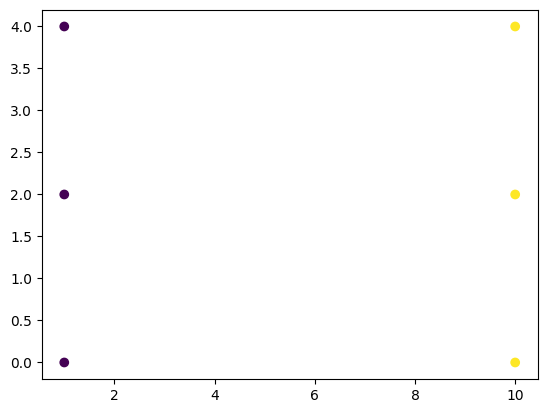

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Toy data (3 clear clusters)
X = np.array([[1,2], [1,4], [1,0], [10,2], [10,4], [10,0]])

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
sil = silhouette_score(X, labels)

print(f'Silhouette: {sil:.2f}')
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

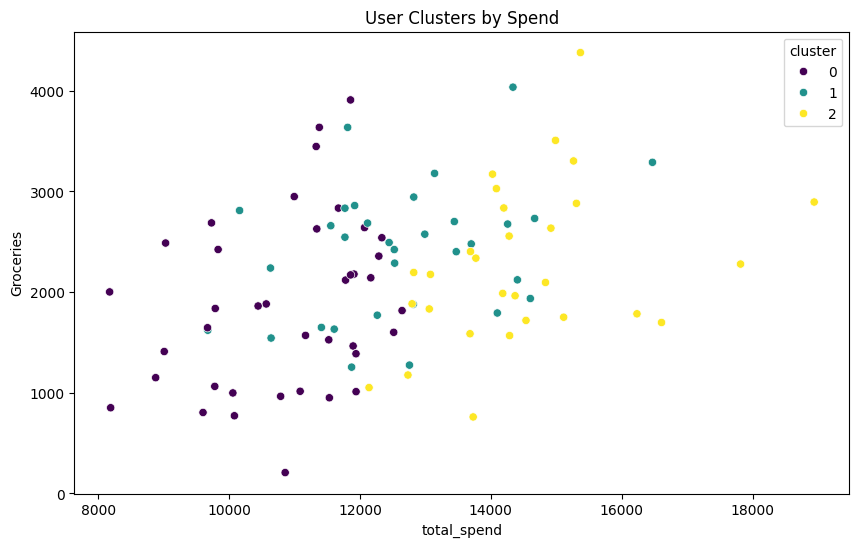

category   Dining Out  Entertainment    Groceries   Healthcare    Transport  \
cluster                                                                       
0         2026.936582    2054.846900  1870.539381  1757.967007  1428.260493   
1         1736.749118    1871.339278  2405.297507  1649.473941  2673.434247   
2         2234.692609    2466.983849  2256.810811  3139.095146  1862.050071   

category    Utilities   total_spend  db_cluster  
cluster                                          
0         1726.975491  10865.525855        -1.0  
1         2311.386616  12647.680707        -1.0  
2         2553.690287  14513.322774        -1.0  


In [9]:
# Viz clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=user_df, x='total_spend', y='Groceries', hue='cluster', palette='viridis')
plt.title('User Clusters by Spend')
plt.show()

# Mean per cluster
cluster_summary = user_df.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)